In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Cpi63QXswYWtNCSOzz9E")
project = rf.workspace("data-bus-tracking").project("bus-track")
version = project.version(4)
dataset = version.download("yolov5")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.8 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstalling cycler-0.12.1:
      Successfully uninstalled cycler-0.12

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to bus-track-4 in yolov5pytorch:: 100%|██████████| 1364/1364 [00:00<00:00, 5284.65it/s]


In [4]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
# install dependencies as necessary
%pip install -qr requirements.txt  # install dependencies (ignore errors)

Cloning into 'yolov5'...
remote: Enumerating objects: 16512, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 16512 (delta 41), reused 49 (delta 15), pack-reused 16408
Receiving objects: 100% (16512/16512), 15.18 MiB | 25.96 MiB/s, done.
Resolving deltas: 100% (11304/11304), done.
/content/yolov5/yolov5


In [5]:
import torch
import shutil
import yaml
import glob
from utils.plots import plot_results


# for displaying images
from IPython.display import Image, display , clear_output
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

In [6]:
clear_output()
print('torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

torch 2.1.0+cu121 _CudaDeviceProperties(name='Tesla V100-SXM2-16GB', major=7, minor=0, total_memory=16151MB, multi_processor_count=80)


## Define Model Configuration and Architecture

For this task, we will use the smallest, fastest base model of YOLOv5.

In [7]:
yolov5 ='/content/bus-track-4/data.yaml'

In [8]:
with open(yolov5, 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [9]:
%cat /content/yolov5/models/yolov5l.yaml

# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license

# Parameters
nc: 80 # number of classes
depth_multiple: 1.0 # model depth multiple
width_multiple: 1.0 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 4]

In [8]:
#  We will use the yolov5s.yaml file as a template to create our custom model
@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [9]:
%%writetemplate /content/yolov5/models/yolov5l.yaml


# Parameters
nc: {num_classes} # number of classes
depth_multiple: 0.33 # model depth multiple
width_multiple: 0.50 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 4], 1, Concat, [1]], # cat backbone P3
    [-1, 3, C3, [256, False]], # 17 (P3/8-small)

    [-1, 1, Conv, [256, 3, 2]],
    [[-1, 14], 1, Concat, [1]], # cat head P4
    [-1, 3, C3, [512, False]], # 20 (P4/16-medium)

    [-1, 1, Conv, [512, 3, 2]],
    [[-1, 10], 1, Concat, [1]], # cat head P5
    [-1, 3, C3, [1024, False]], # 23 (P5/32-large)

    [[17, 20, 23], 1, Detect, [nc, anchors]], # Detect(P3, P4, P5)
  ]

In [10]:
# train yolov5s on custom data for 100 epochs
# time its performance
%time
%cd /content/yolov5/
!python3 train.py --img 640 --batch 32 --epochs 100 --data '/content/bus-track-4/data.yaml' --weights yolov5l.pt --name tracking_bus_number --cache

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs
/content/yolov5
2024-03-09 17:29:50.467956: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-09 17:29:50.468004: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-09 17:29:50.469333: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5l.pt, cfg=, data=/content/bus-track-4/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evol

## Evaluate Custom YOLOv5 Detector Performance

Training losses and performance metrics are saved to Tensorboard and also to a logfile defined above with the **--name** flag when we train. In our case, we named this `yolov5s_results`. (If given no name, it defaults to `results.txt`.) The results file is plotted as a png after training completes.

In [11]:
%load_ext tensorboard
%tensorboard --logdir runs

<IPython.core.display.Javascript object>

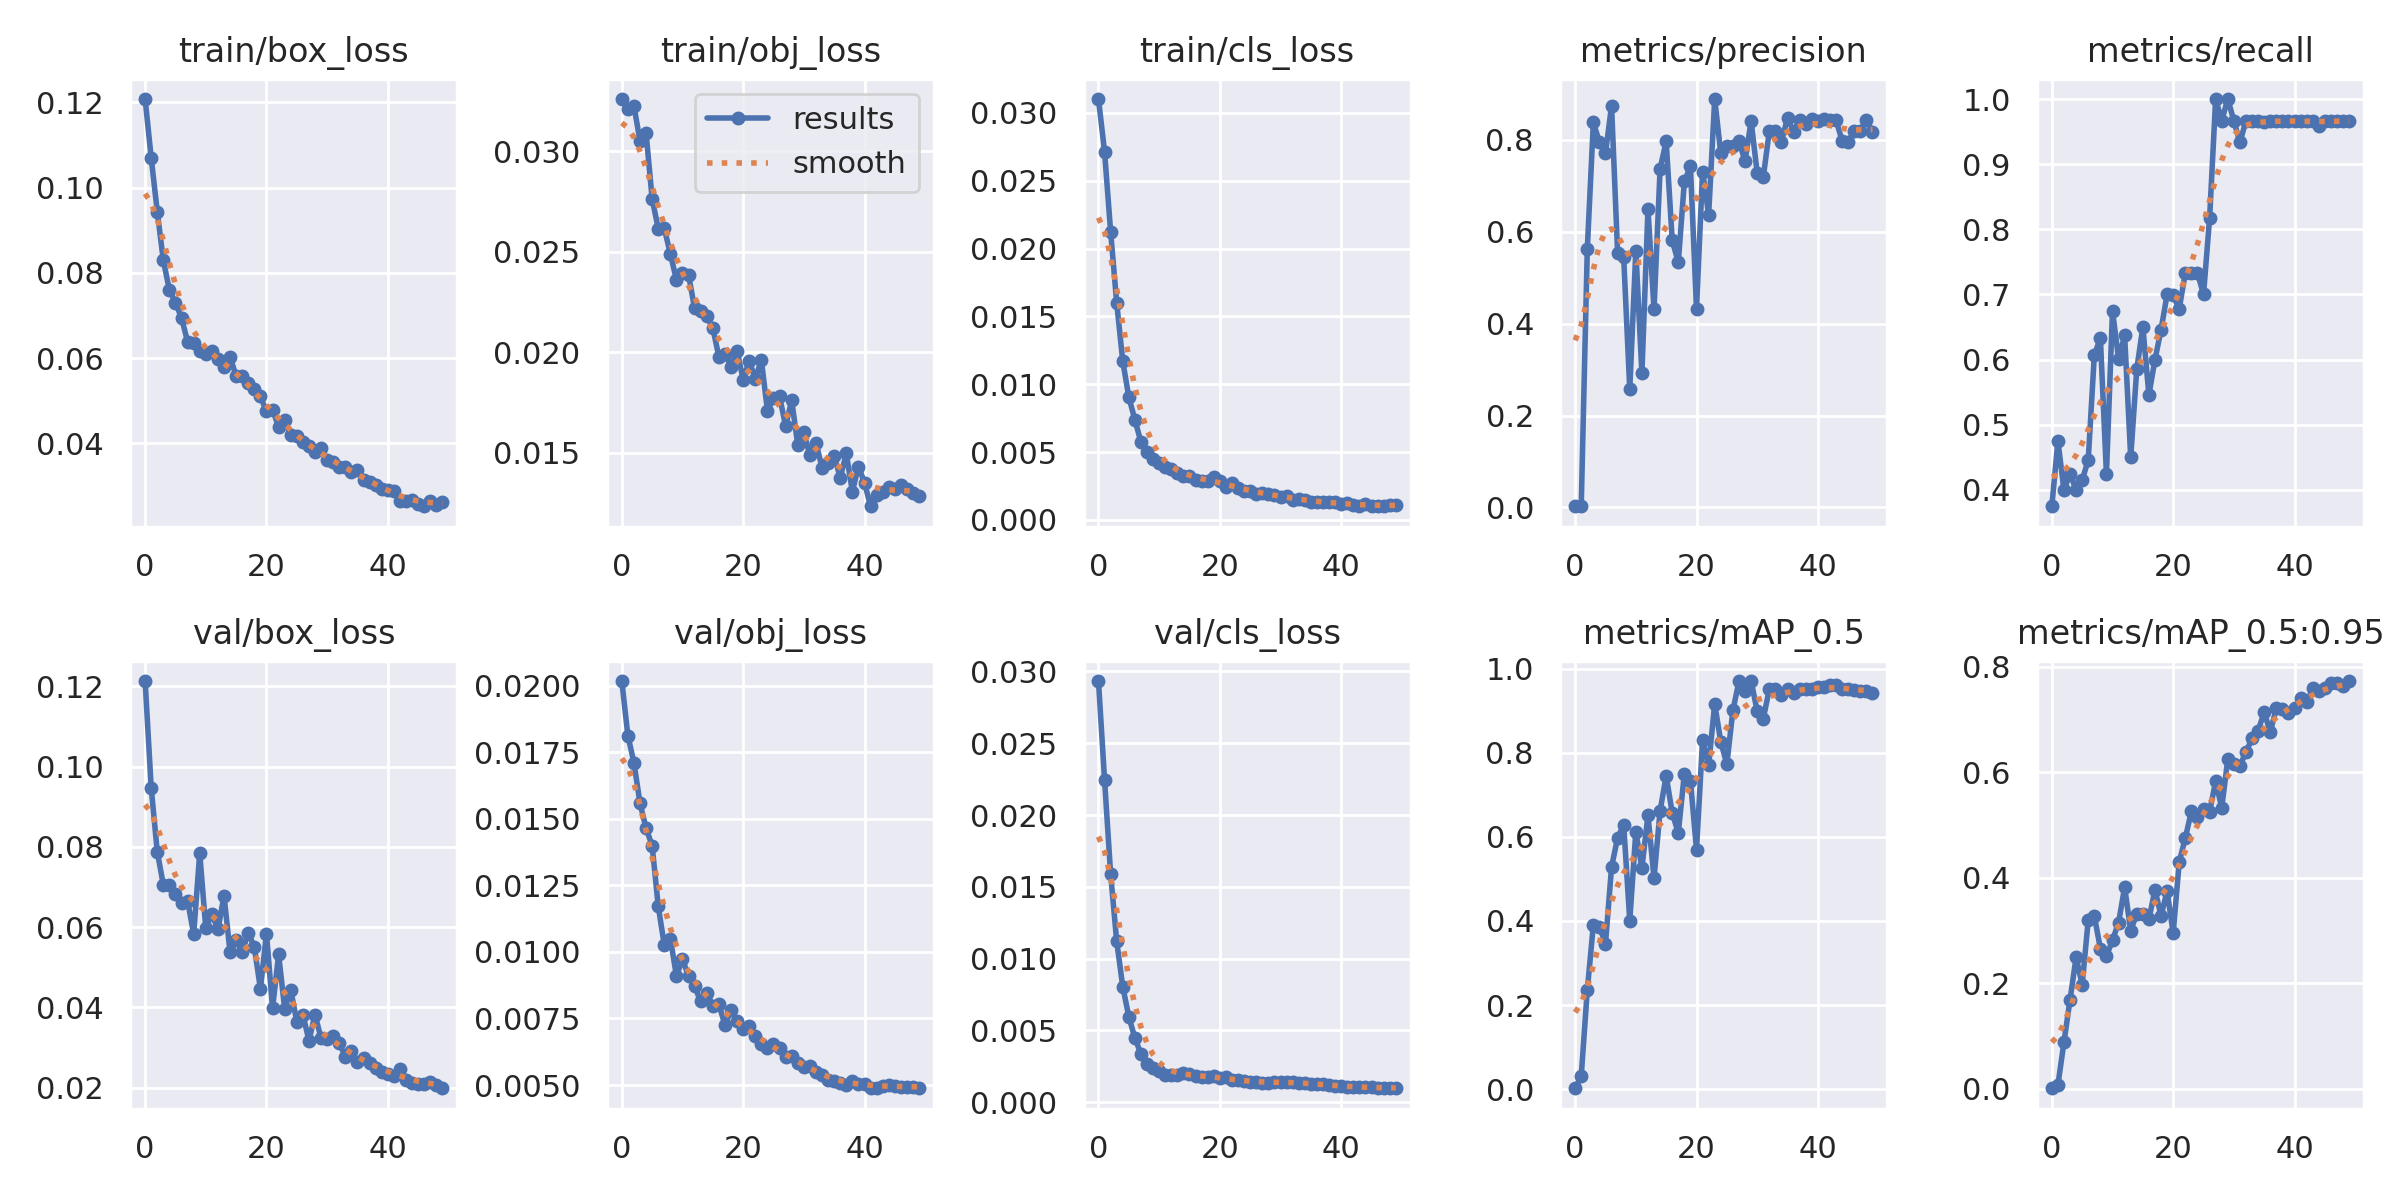

In [ ]:
Image(filename='/content/yolov5/runs/train/tracking_bus_number/results.png', width=1000)  # view results.png

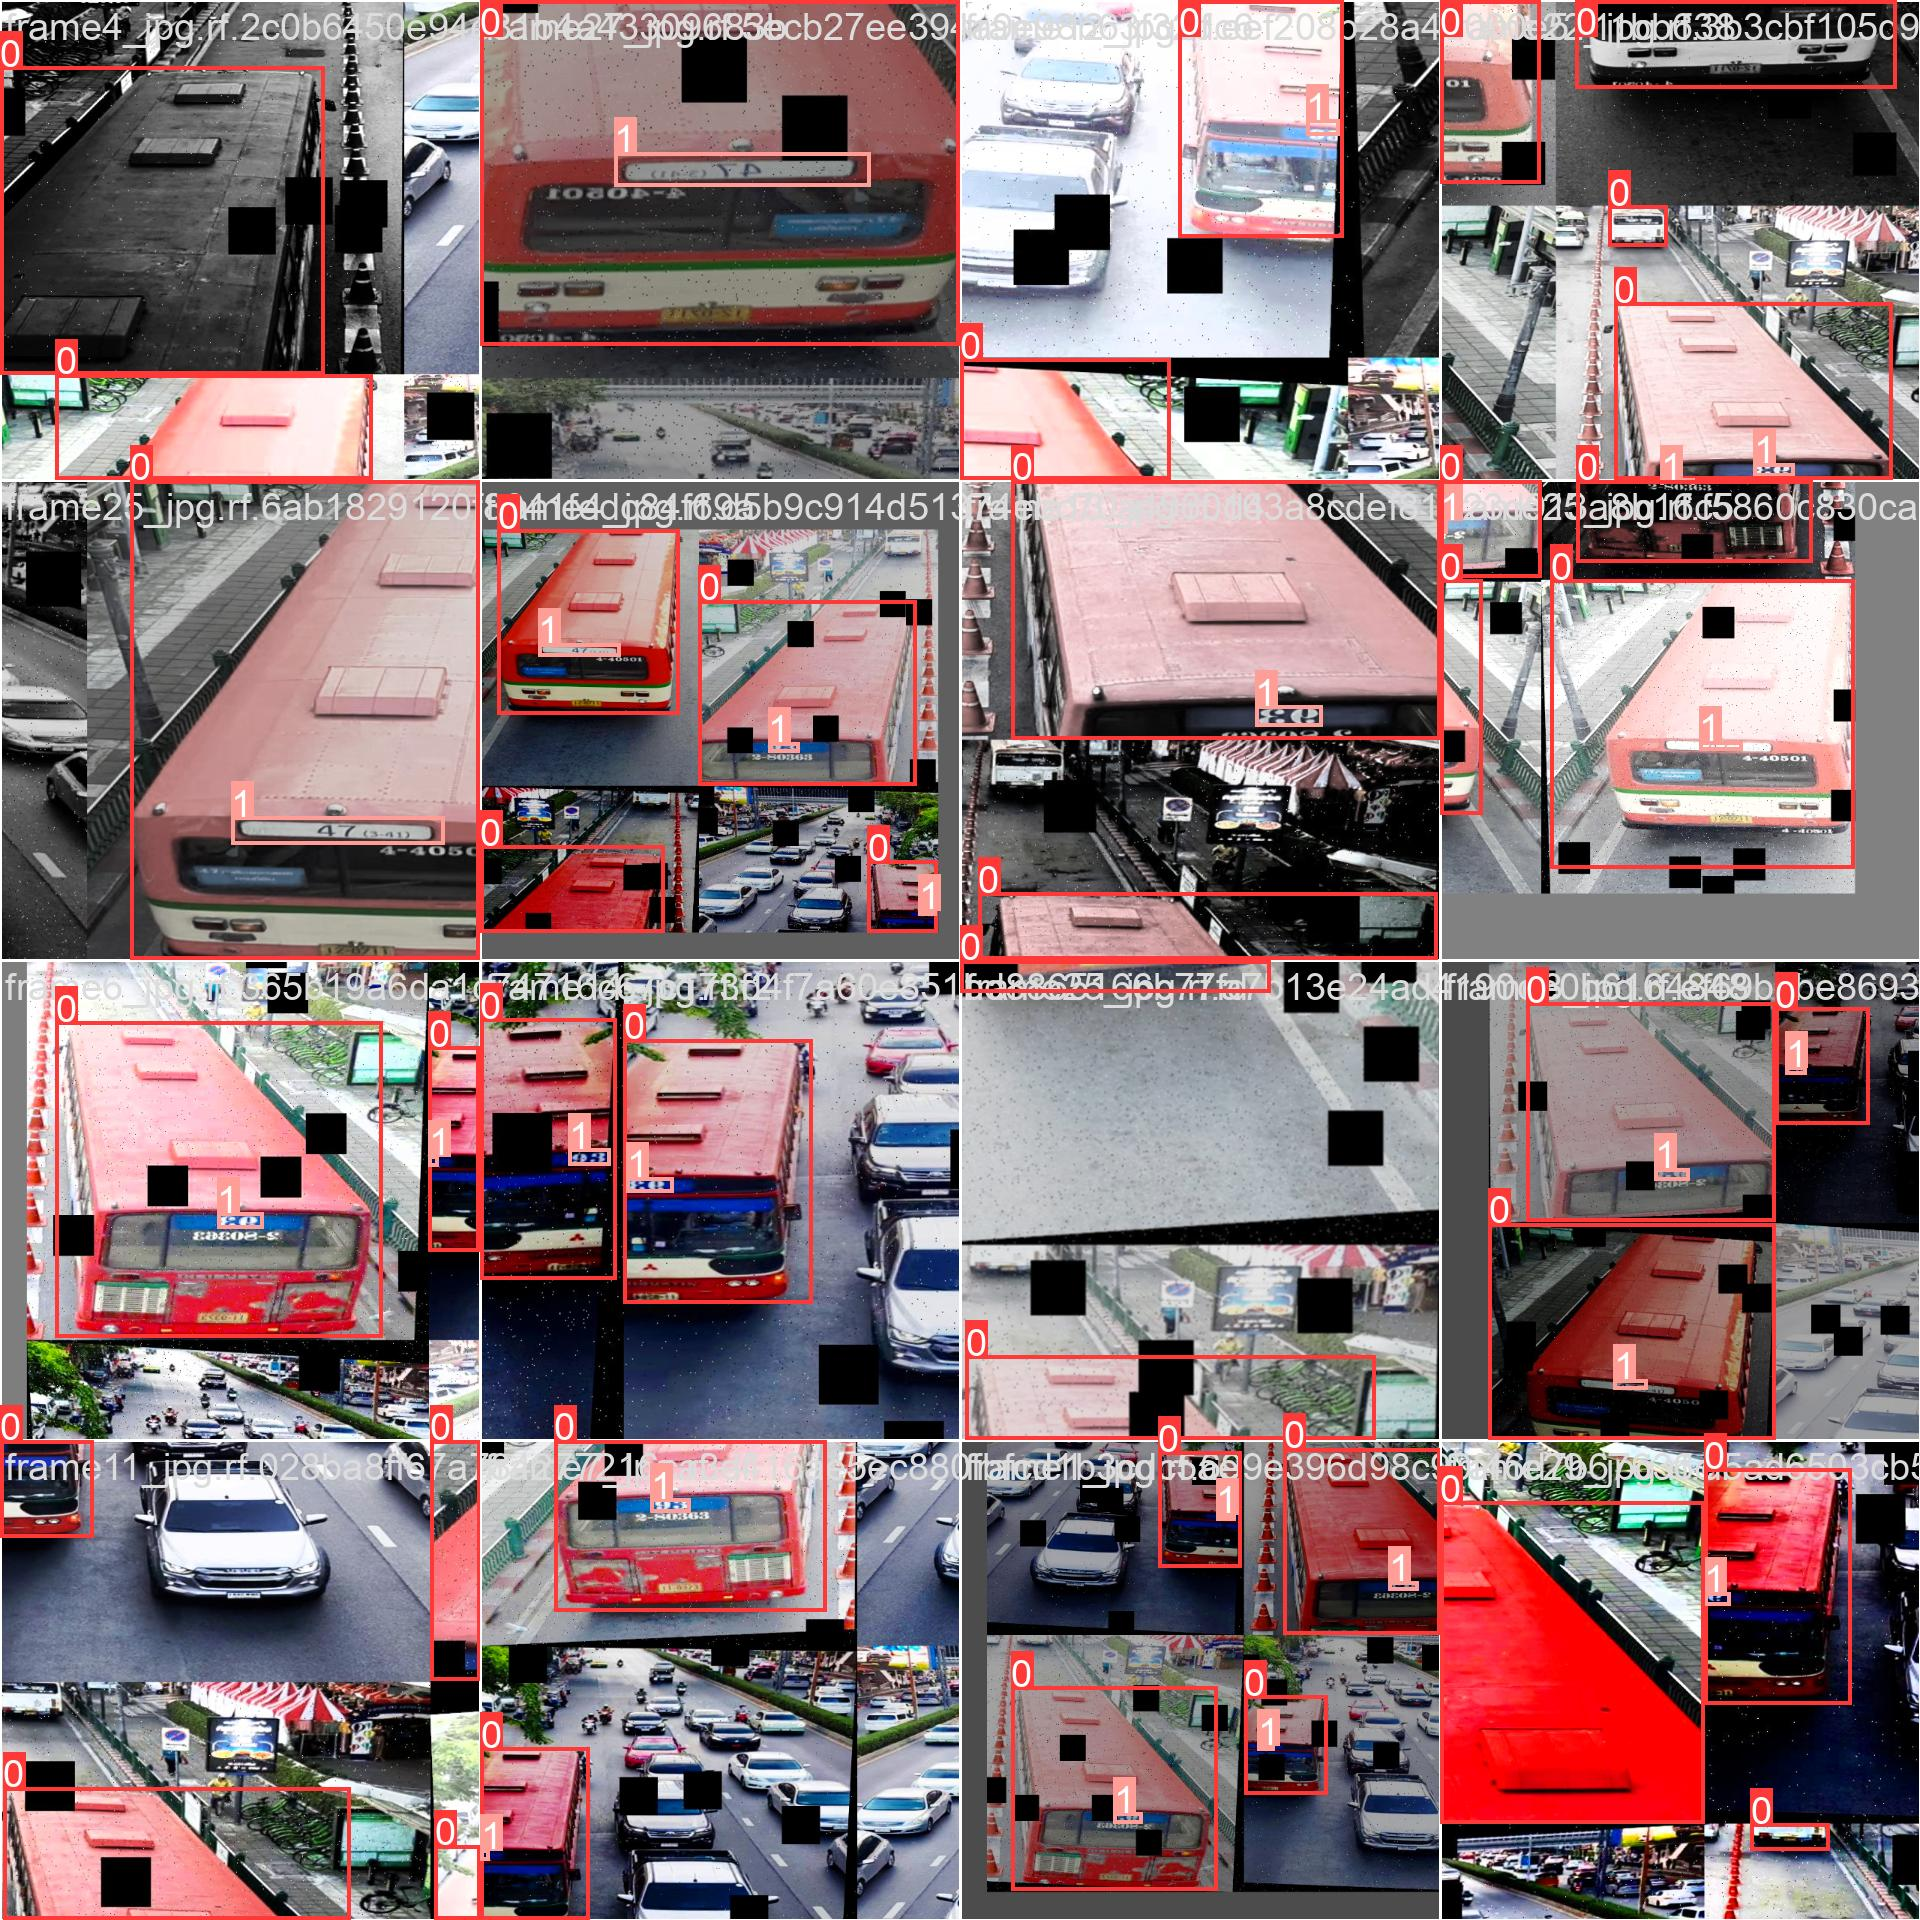

In [ ]:
Image(filename='/content/yolov5/runs/train/tracking_bus_number/train_batch0.jpg', width=1000)  # view results.png

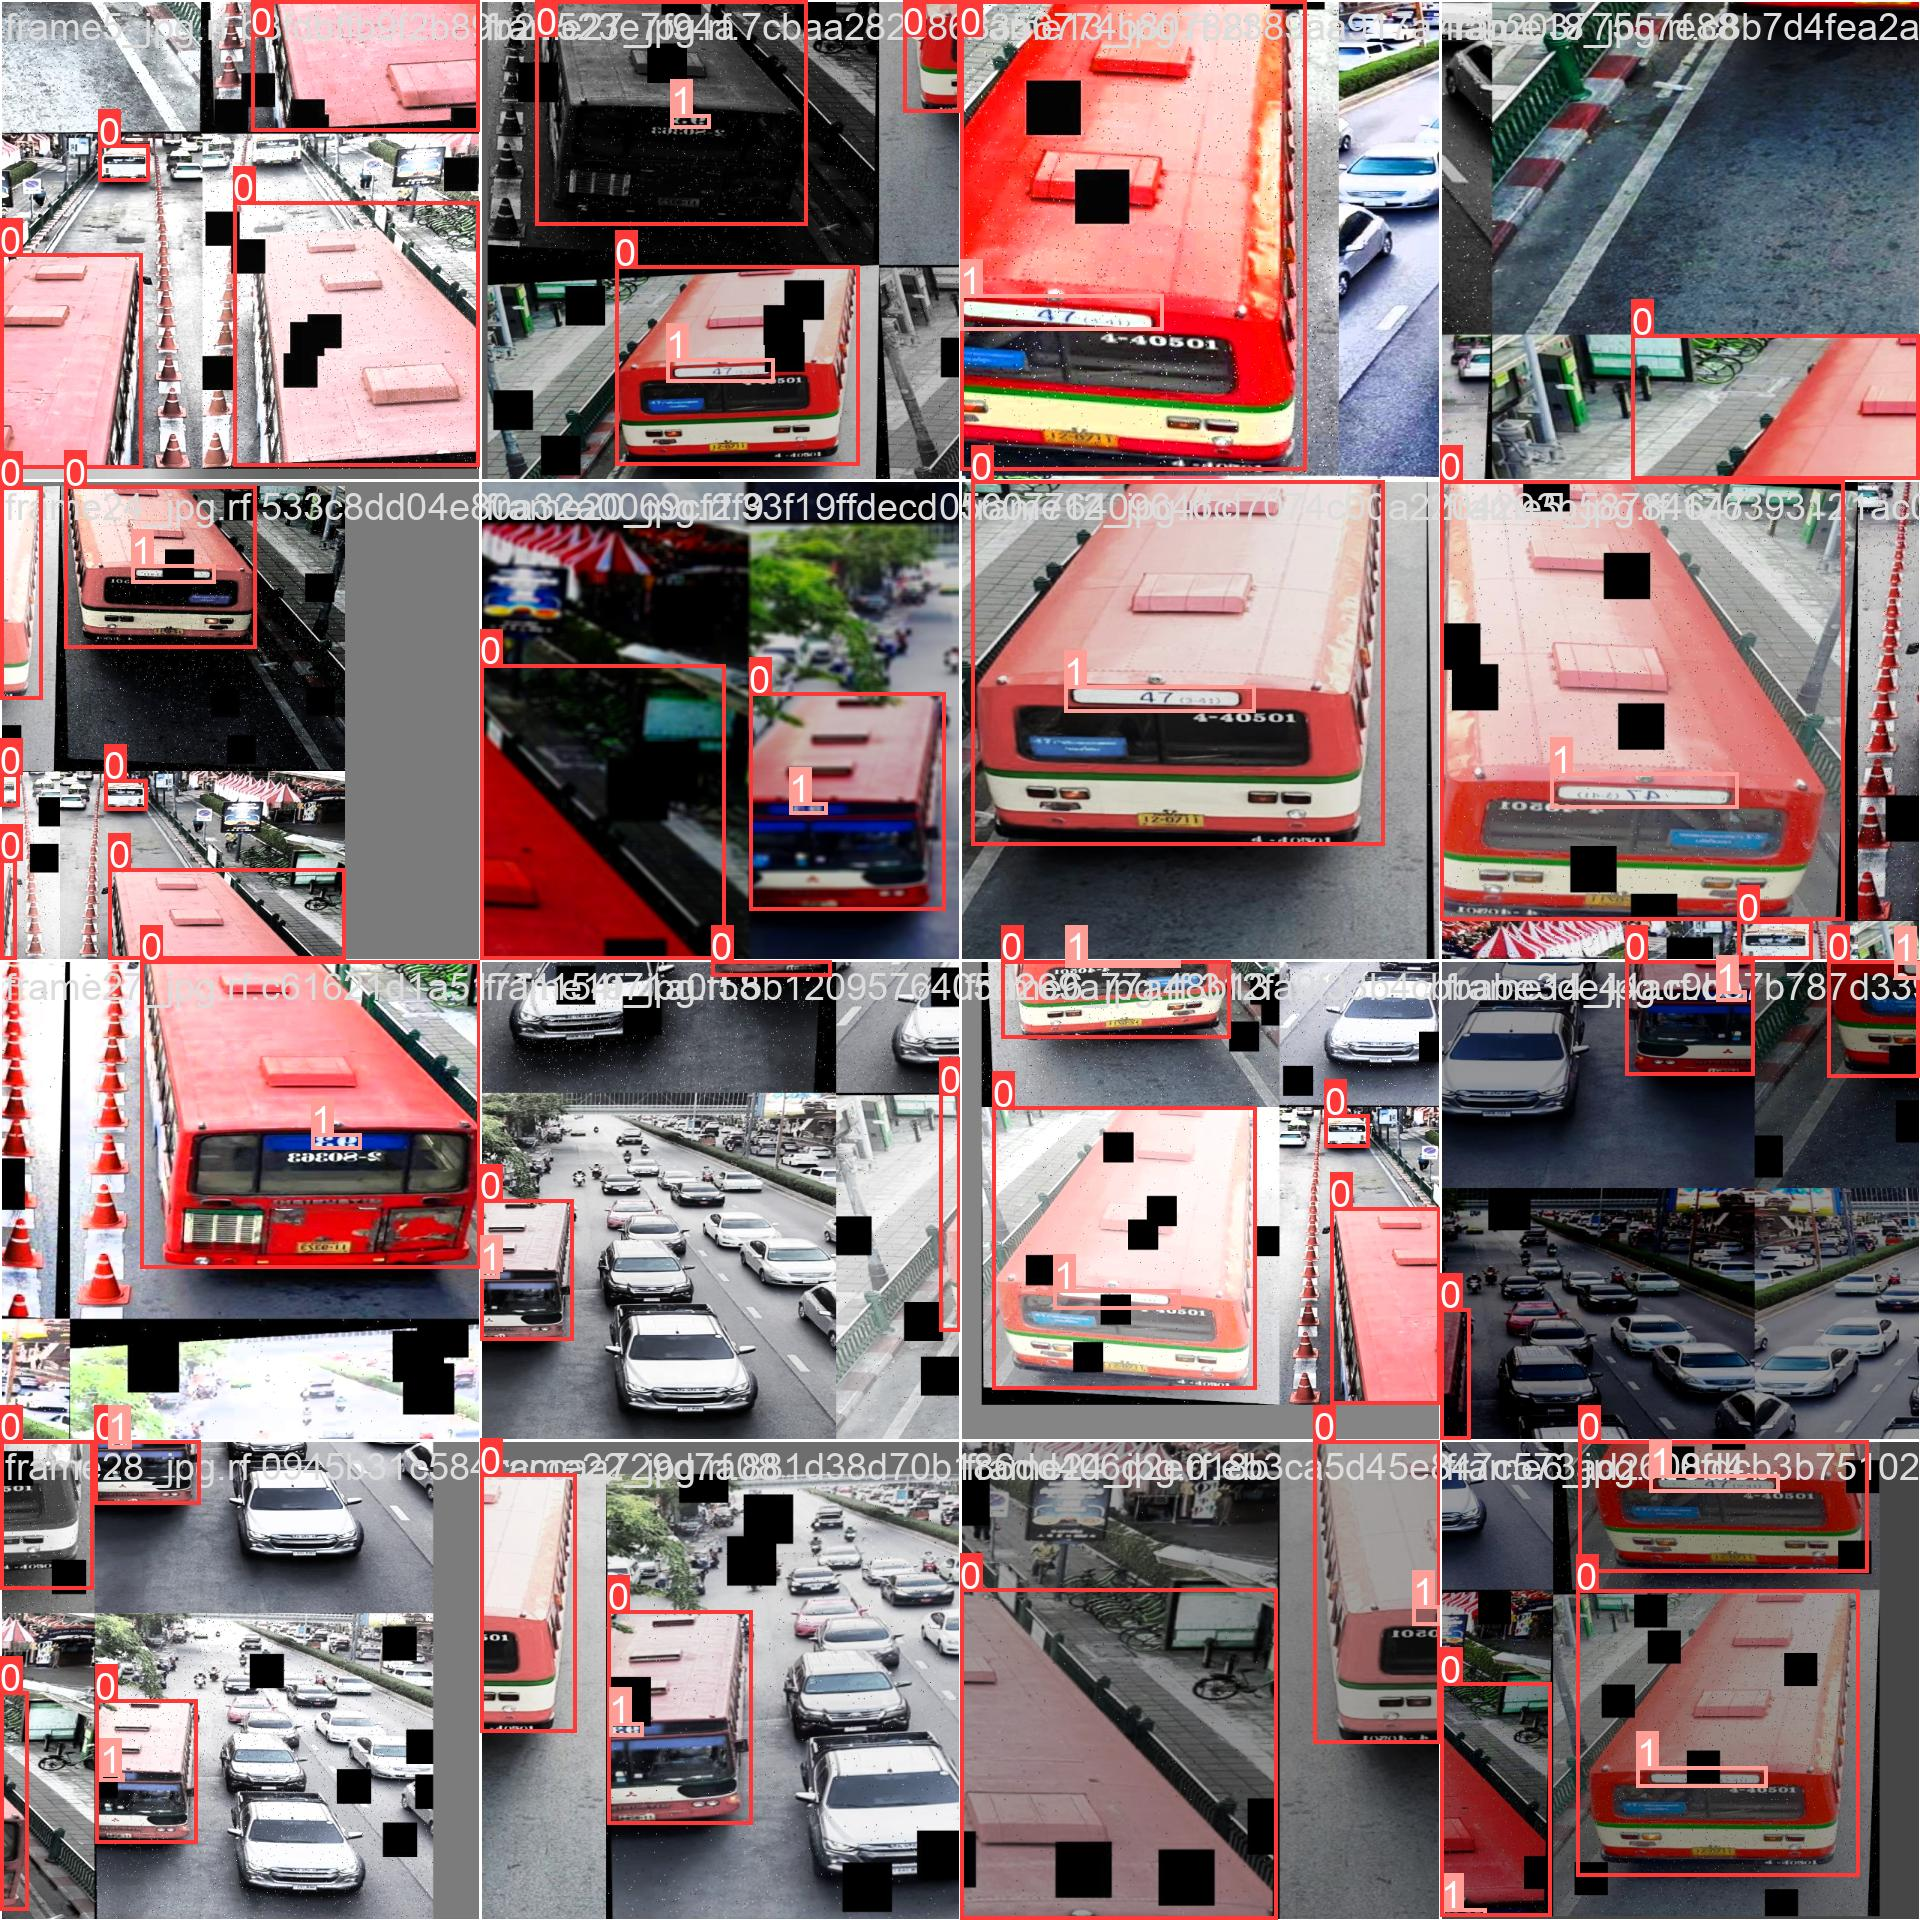

In [ ]:
Image(filename='/content/yolov5/runs/train/tracking_bus_number/train_batch1.jpg', width=1000)  # view results.png

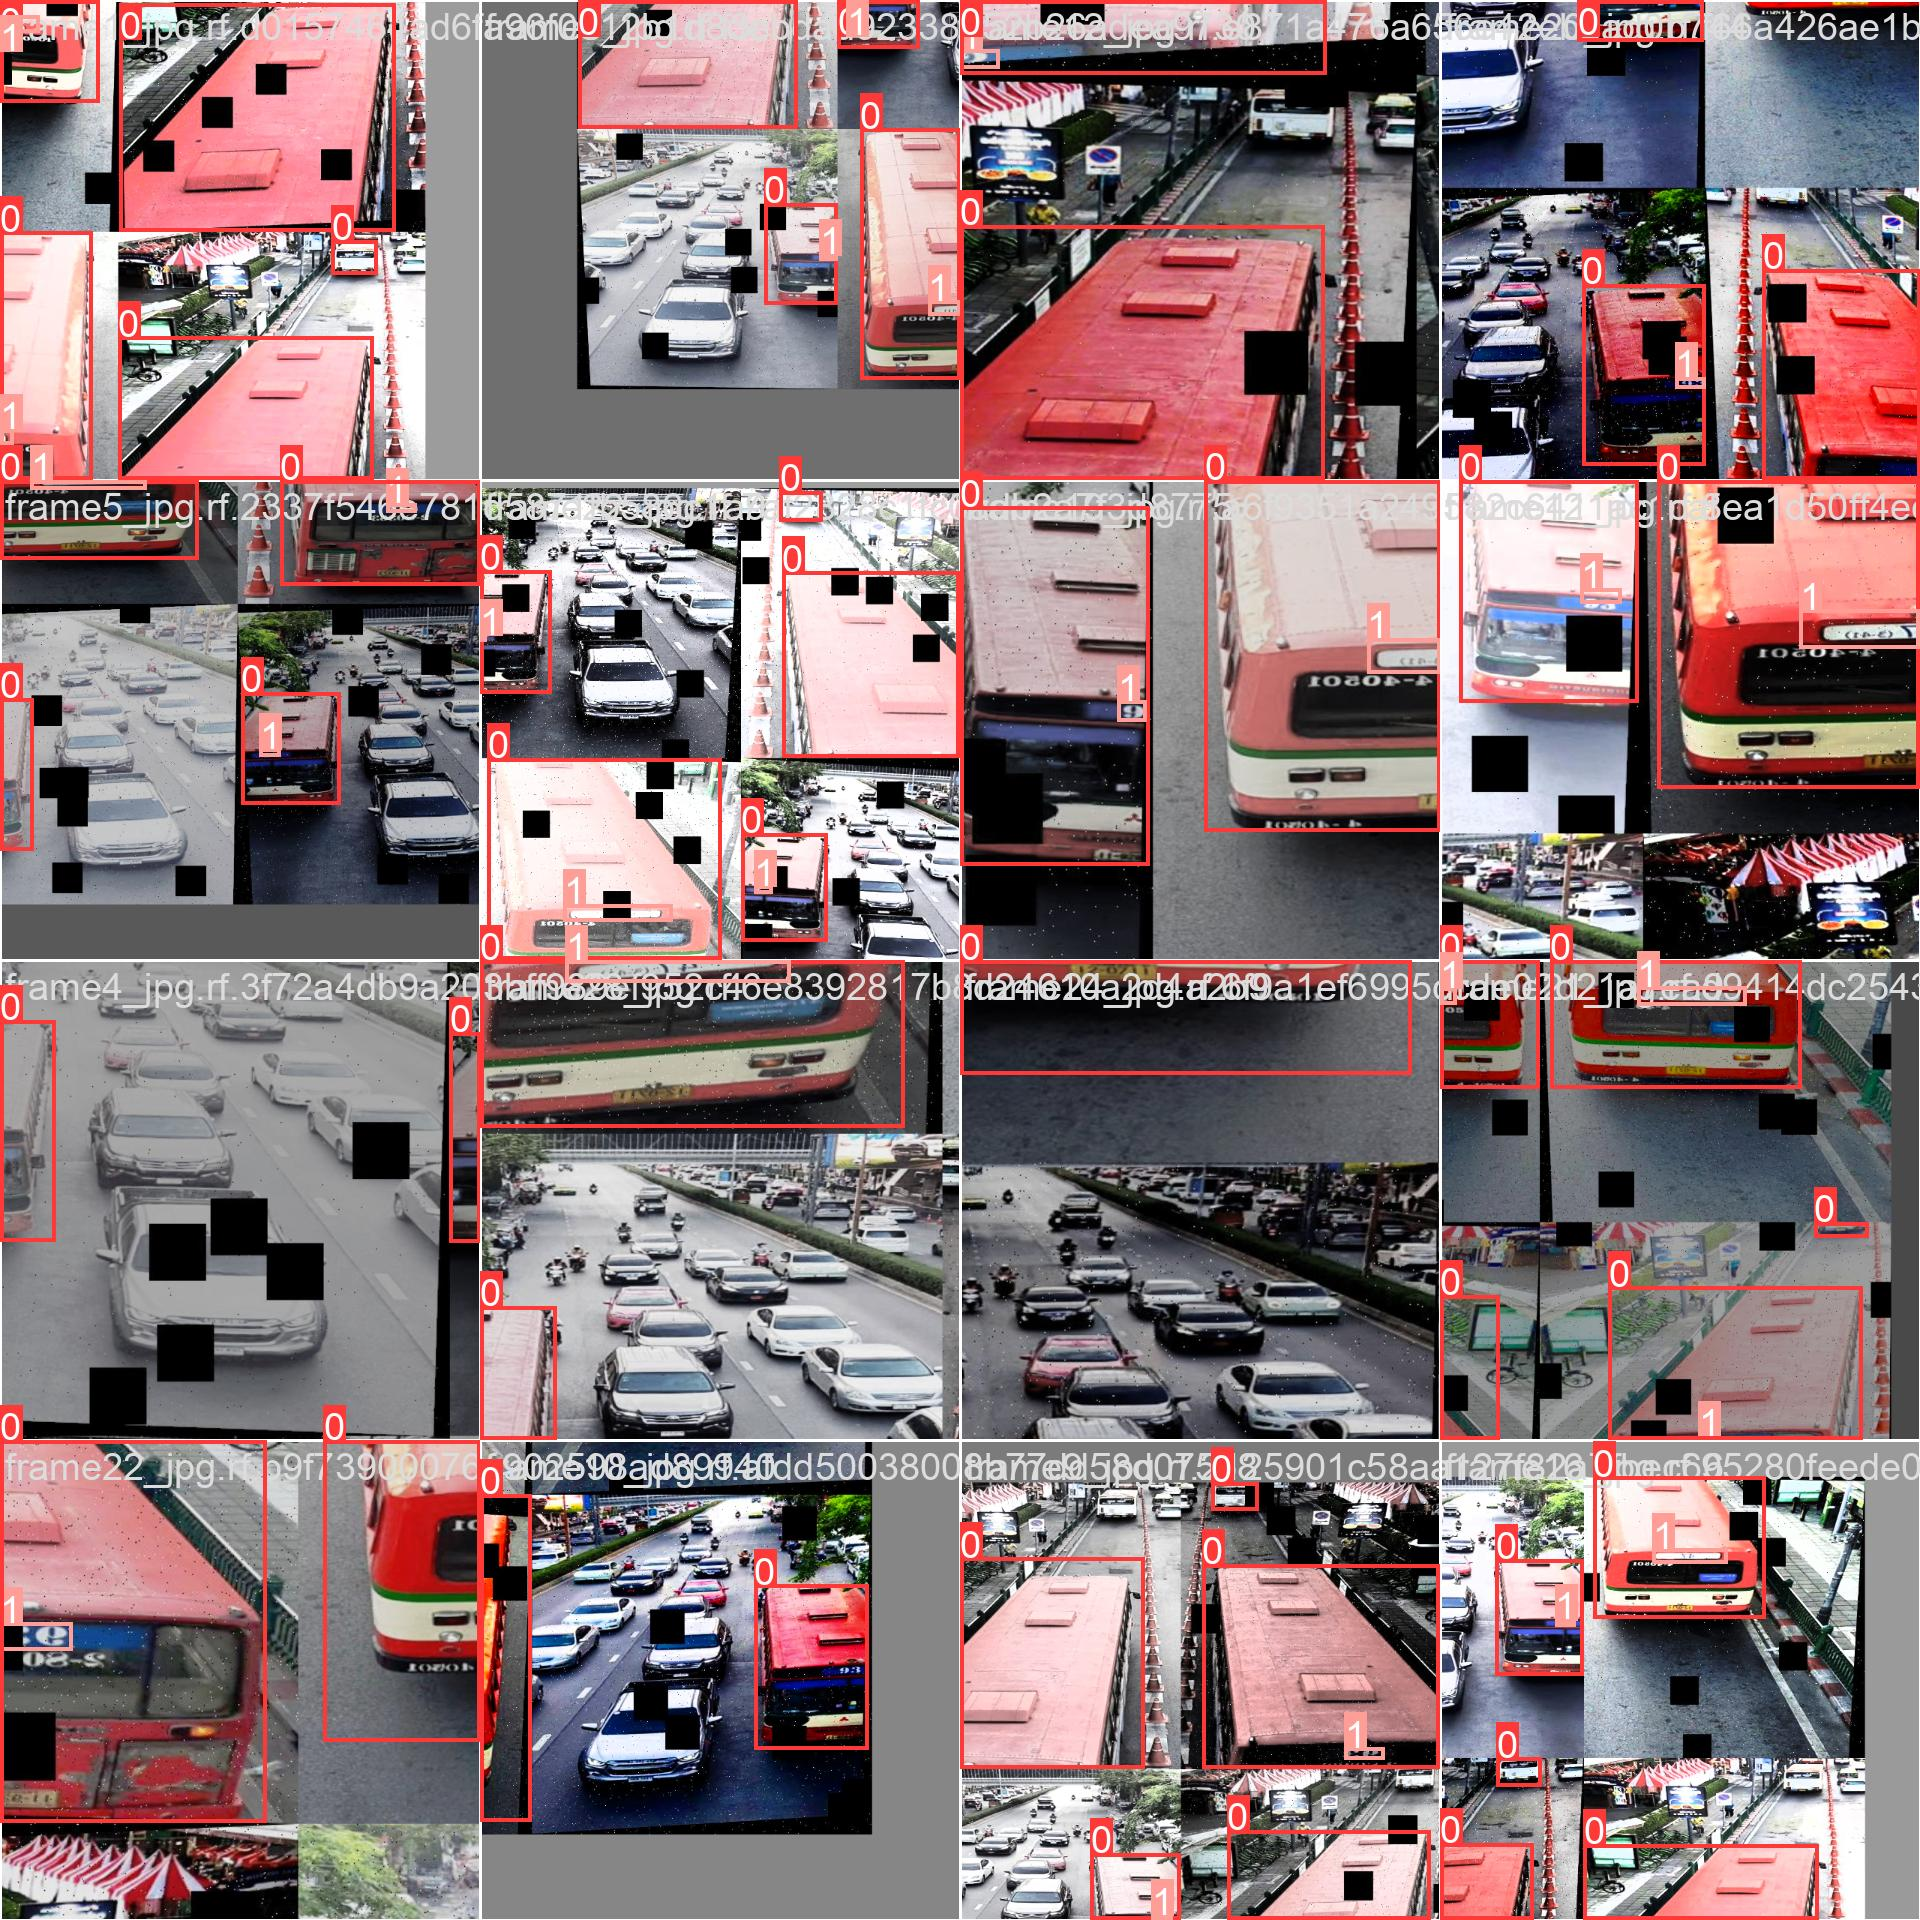

In [ ]:
Image(filename='/content/yolov5/runs/train/tracking_bus_number/train_batch2.jpg', width=1000)  # view results.png

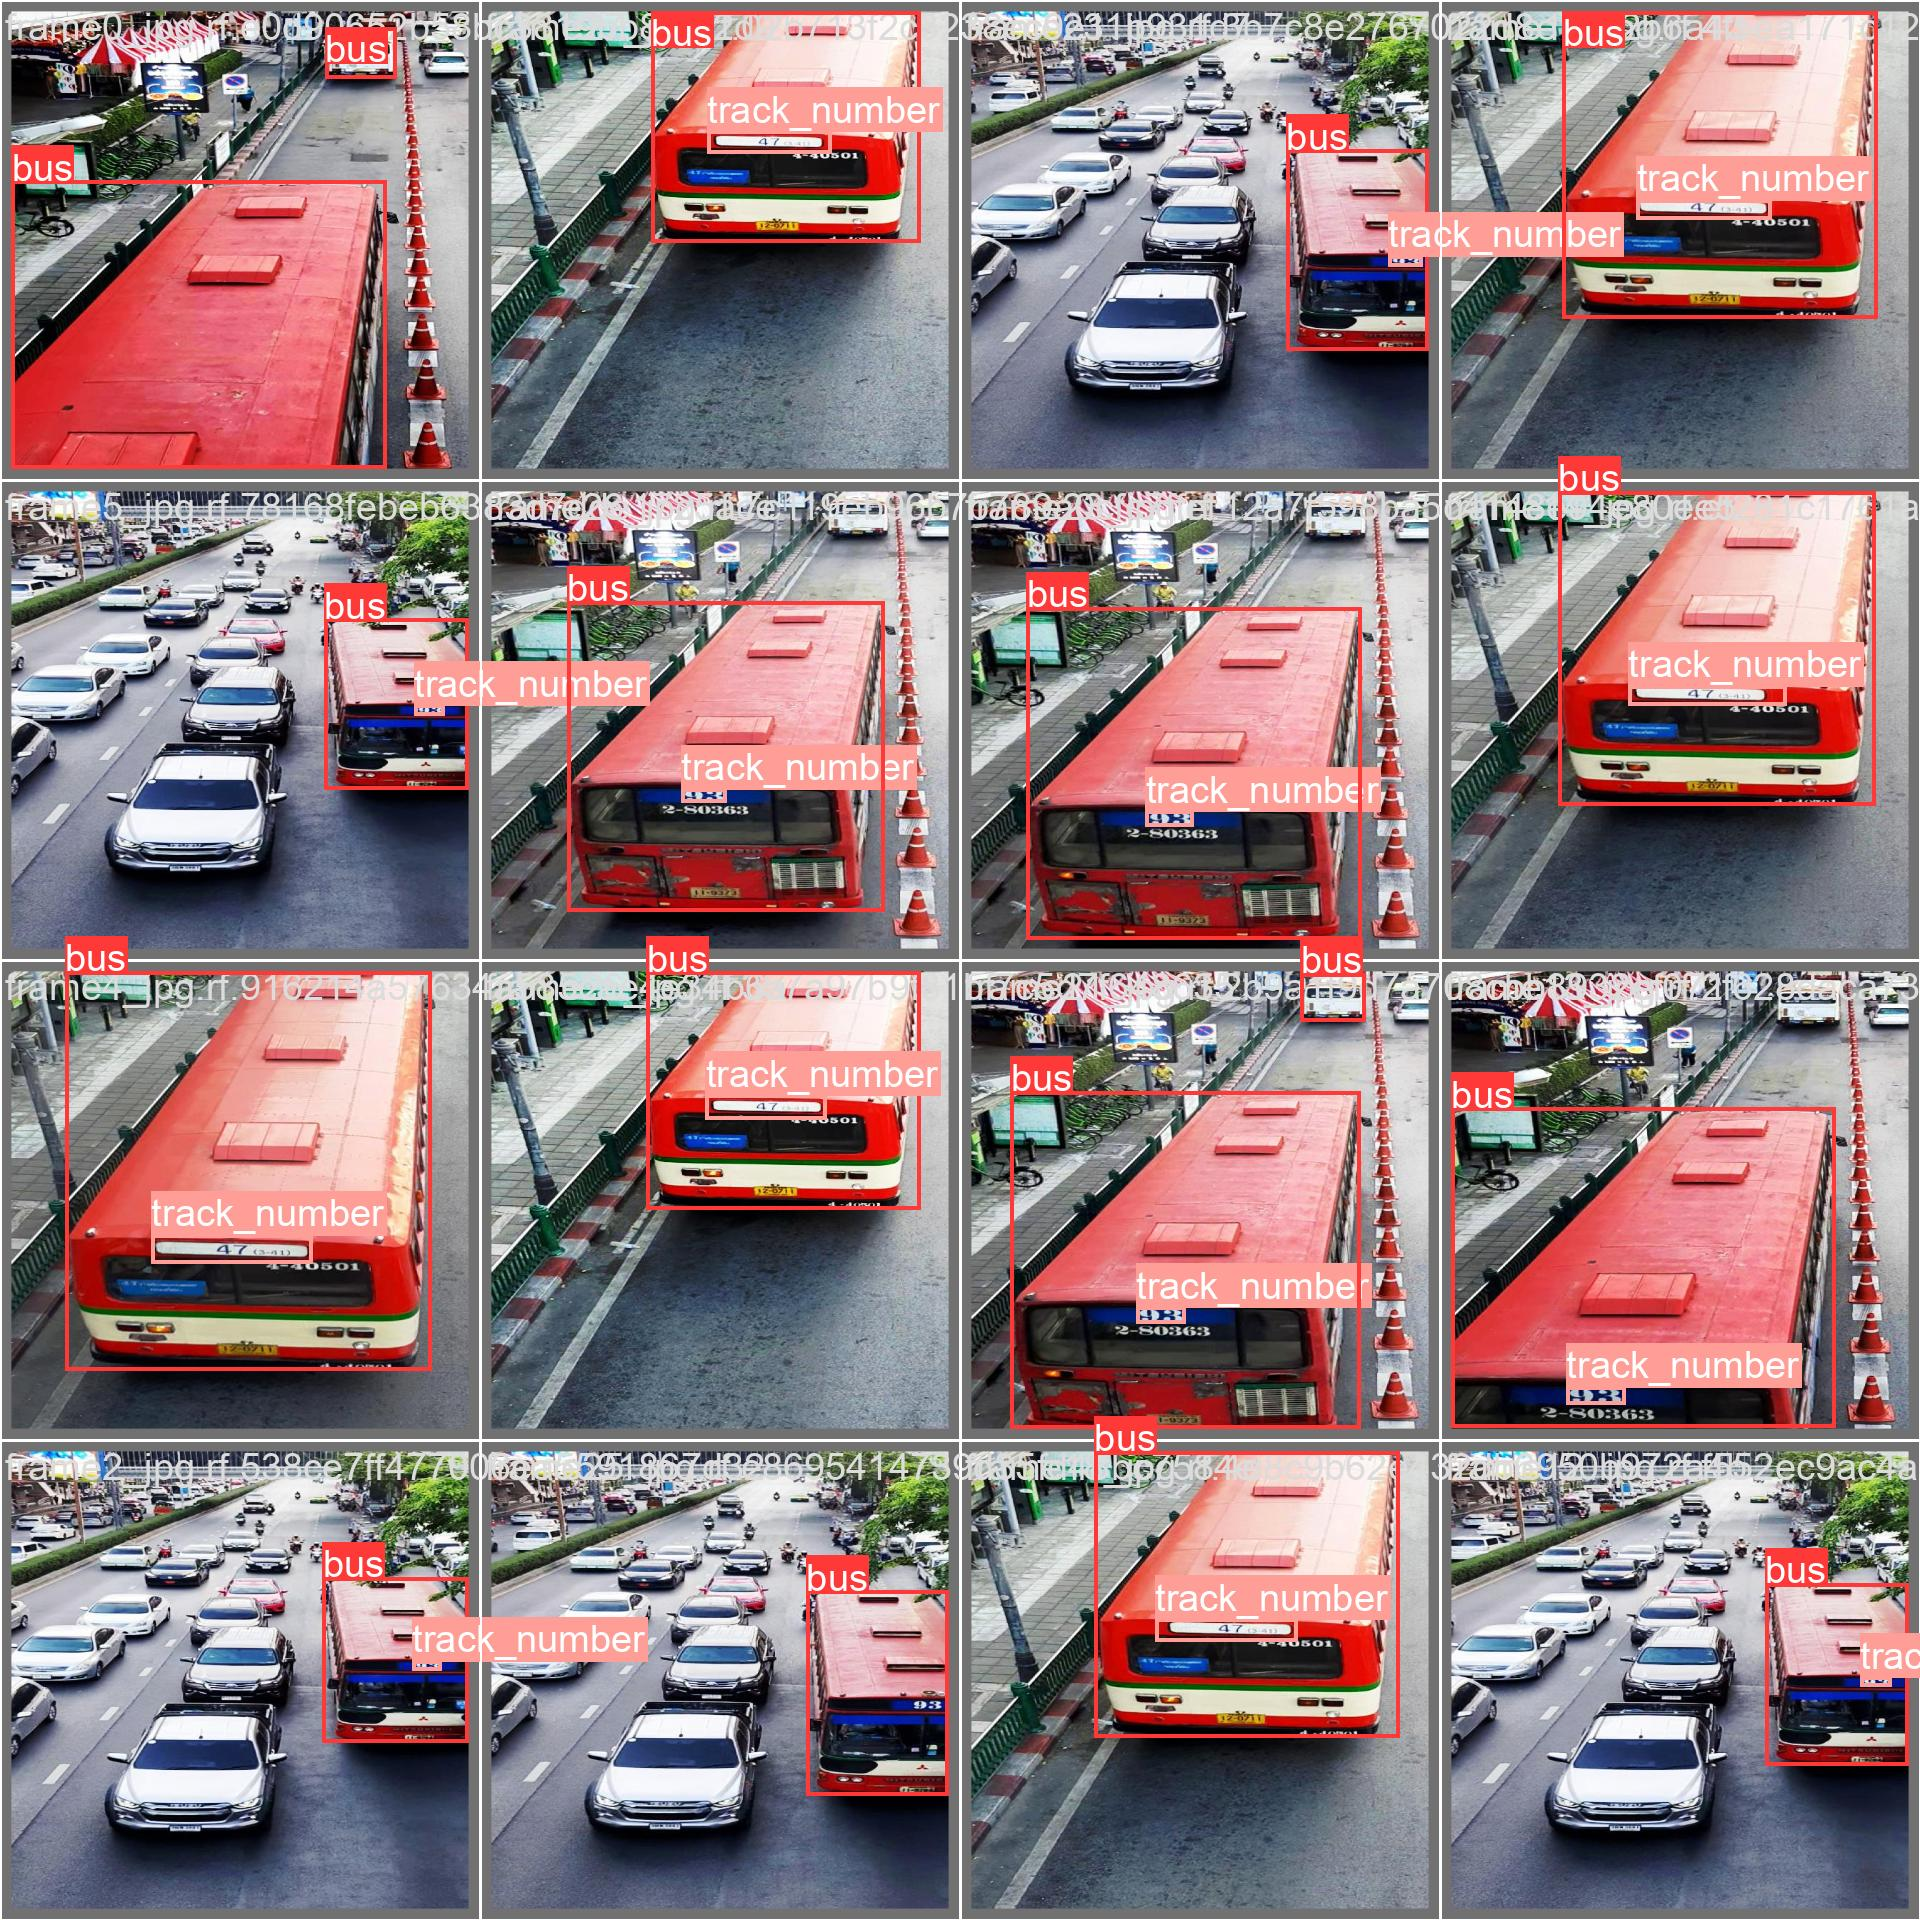

In [ ]:
Image(filename='/content/yolov5/runs/train/tracking_bus_number/val_batch0_labels.jpg', width=1000)  # view results.png

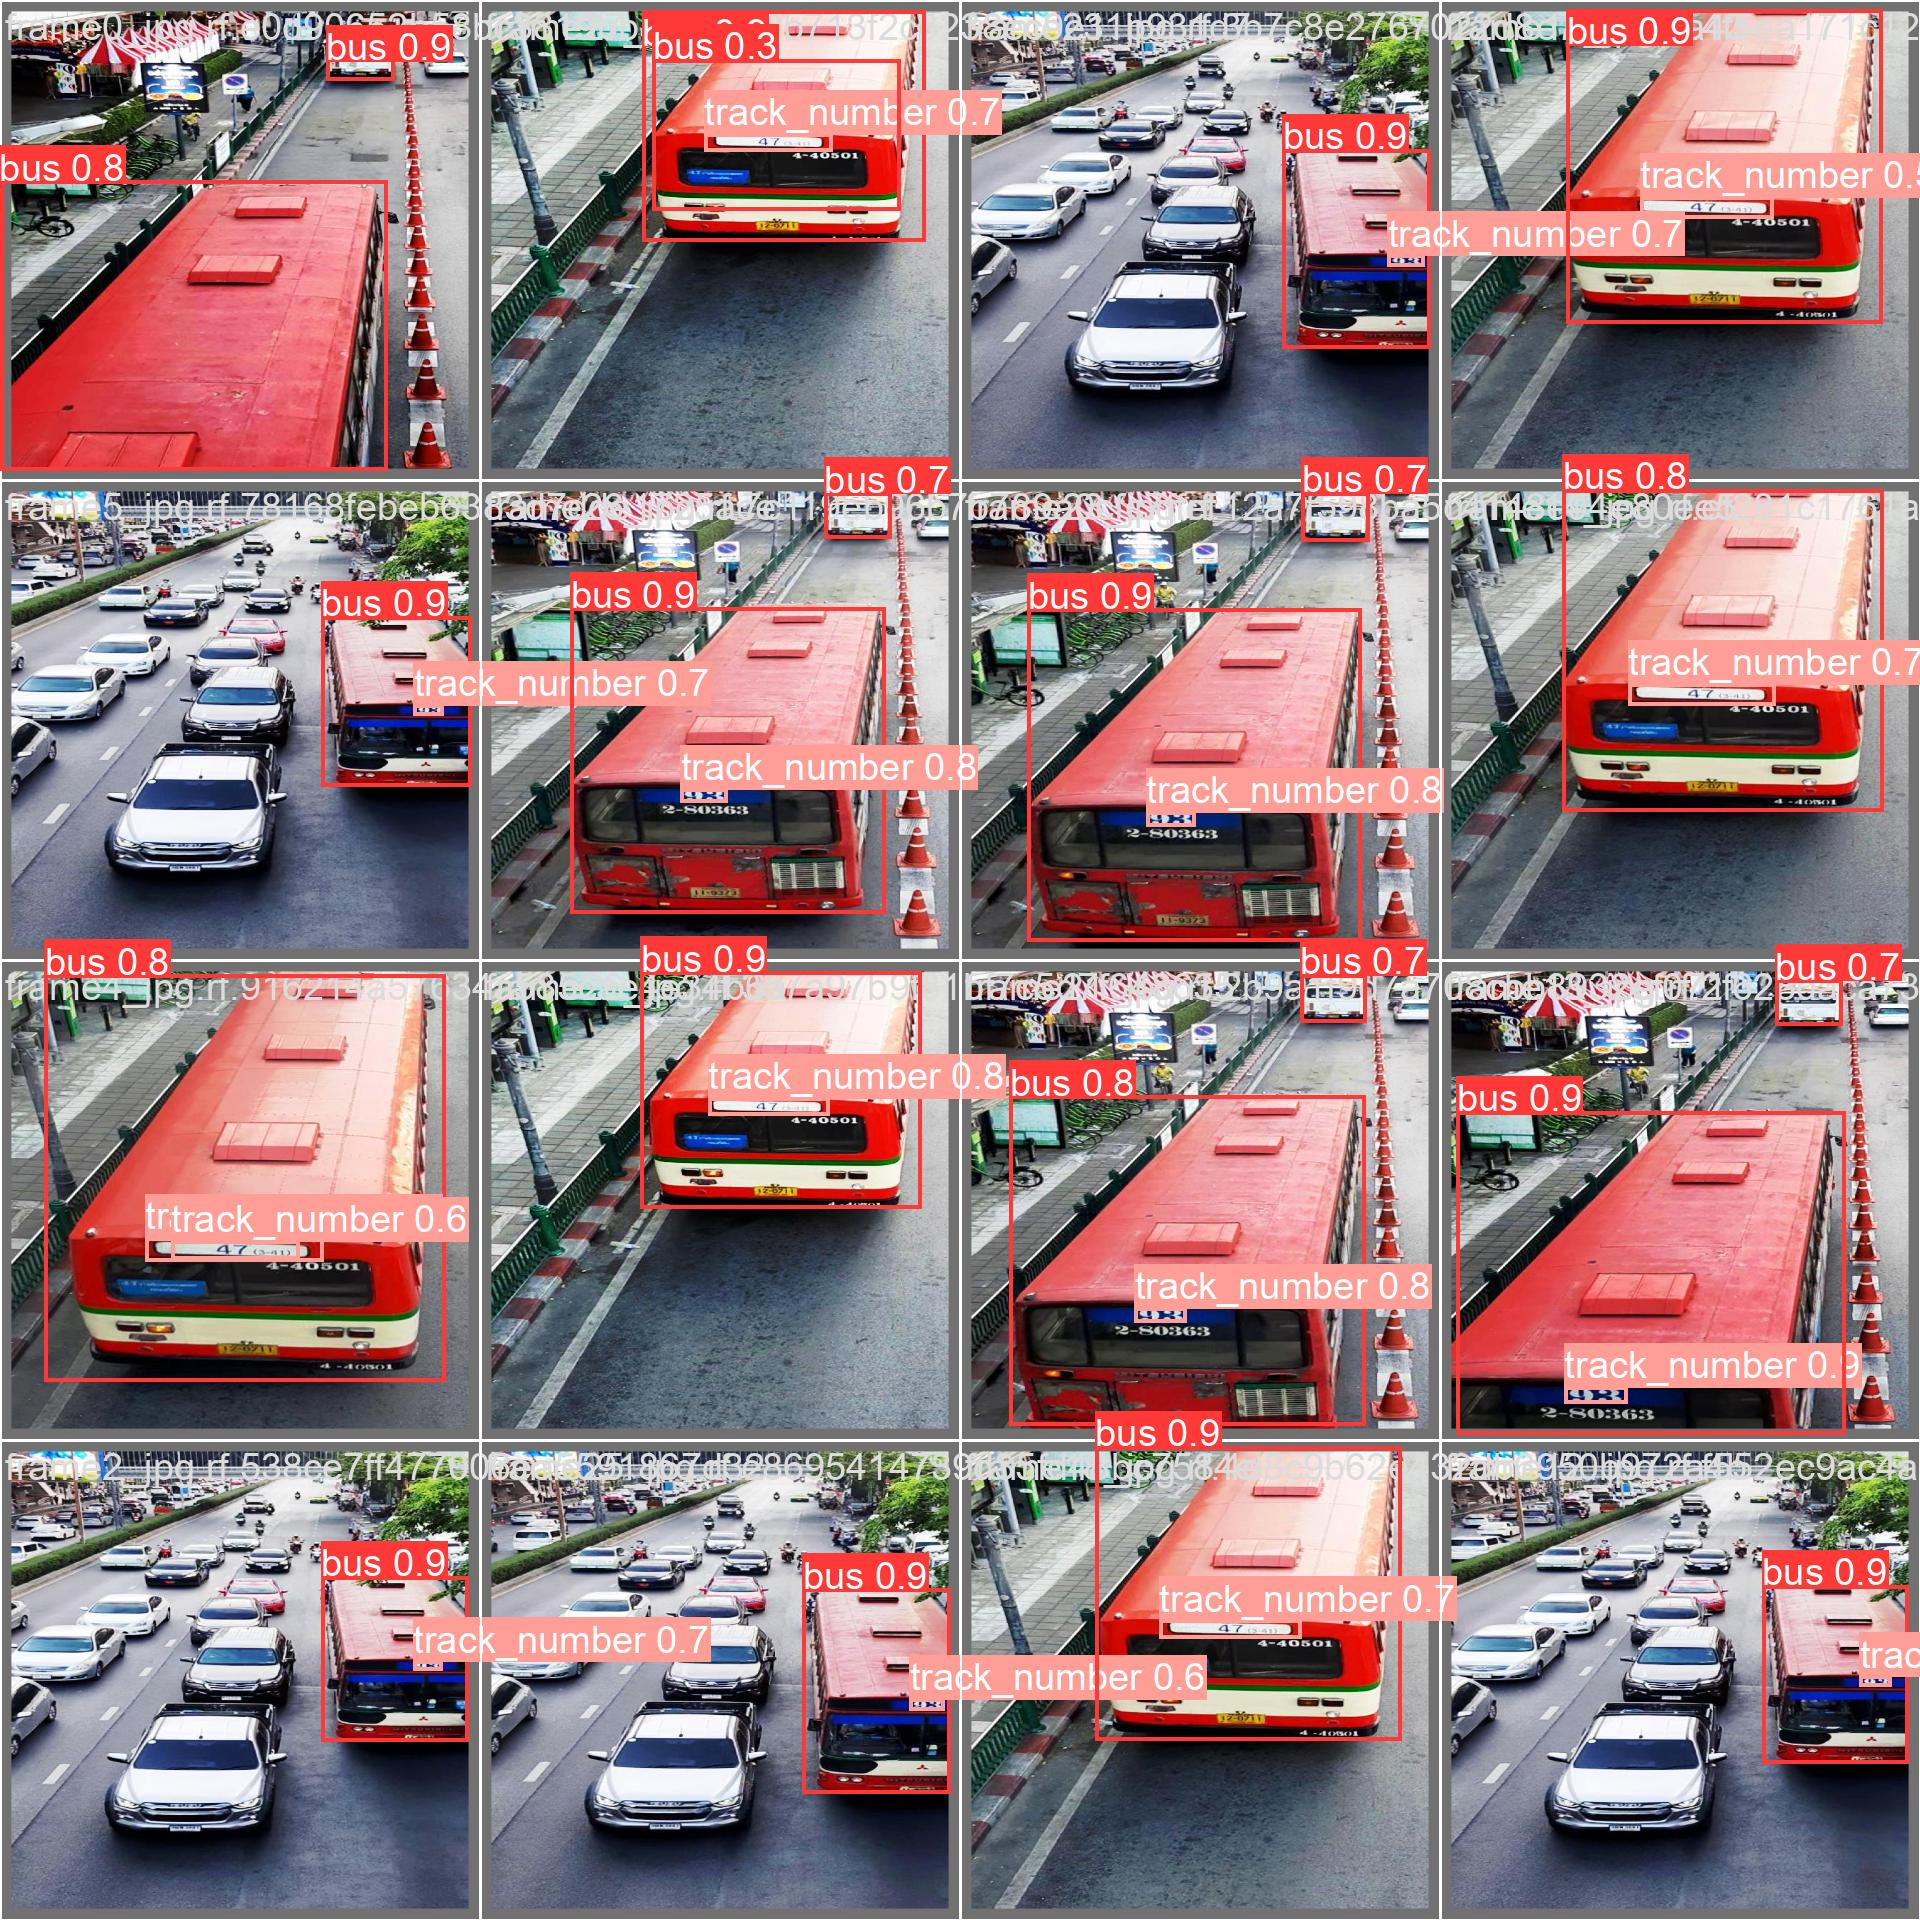

In [ ]:
Image(filename='/content/yolov5/runs/train/tracking_bus_number/val_batch0_pred.jpg', width=1000)  # view results.png